<a href="https://colab.research.google.com/github/kouchan0708/Naka-Kotaro-quant-macro-last-assignment/blob/main/Quant_macro_last_assign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(1)

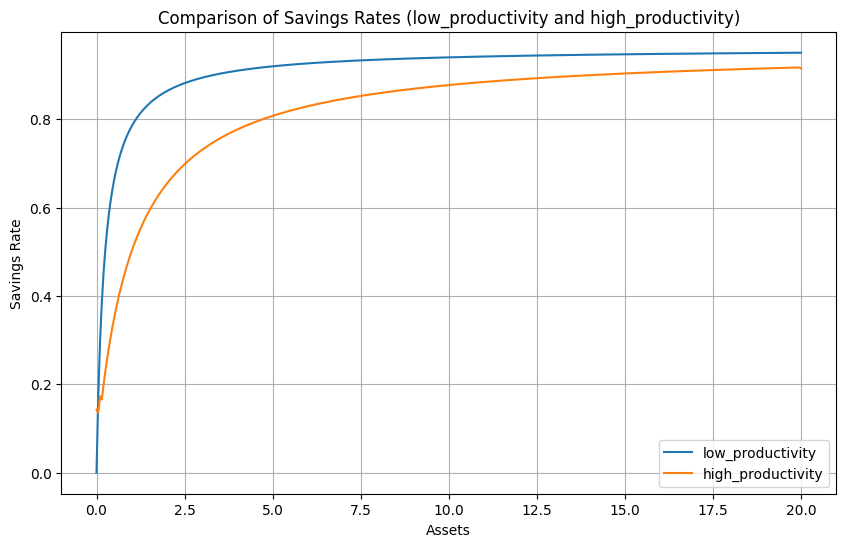

In [22]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen's method to discretize the AR(1) process
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

# Set parameters
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH, 'a_l': a_l, 'a_u': a_u}
    return param

# Solve household problem
def solve_household(param, r, w):
    NA, NH, h, a_l, a_u, sigma, beta, pi = param['NA'], param['NH'], param['h'], param['a_l'], param['a_u'], param['sigma'], param['beta'], param['pi']
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)

    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol, test = 1e-6, 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih] + beta * np.dot(v, pi[ih, :])
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus.astype(int)]
    c = w*h[:, np.newaxis] + (1.0 + r)*a[np.newaxis, :] - aplus.T
    return aplus, iaplus, c

# Plot savings rate
def plot_savings_rate(param, r, w, title):
    decisions = solve_household(param, r, w)
    aplus, c = decisions[0], decisions[2]
    a = np.linspace(param['a_l'], param['a_u'], param['NA'])

    plt.figure(figsize=(10, 6))
    for ih in range(param['NH']):
        if ih == 0:
            label = 'low_productivity'
        else:
            label = 'high_productivity'
        plt.plot(a, aplus[:, ih]/(c[ih, :] + aplus[:, ih]), label=label)
    plt.xlabel("Assets")
    plt.ylabel("Savings Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
param = setPar()
r, w = 0.04, 1

# Plot
plot_savings_rate(param, r, w, "Comparison of Savings Rates (low_productivity and high_productivity)")


(2)

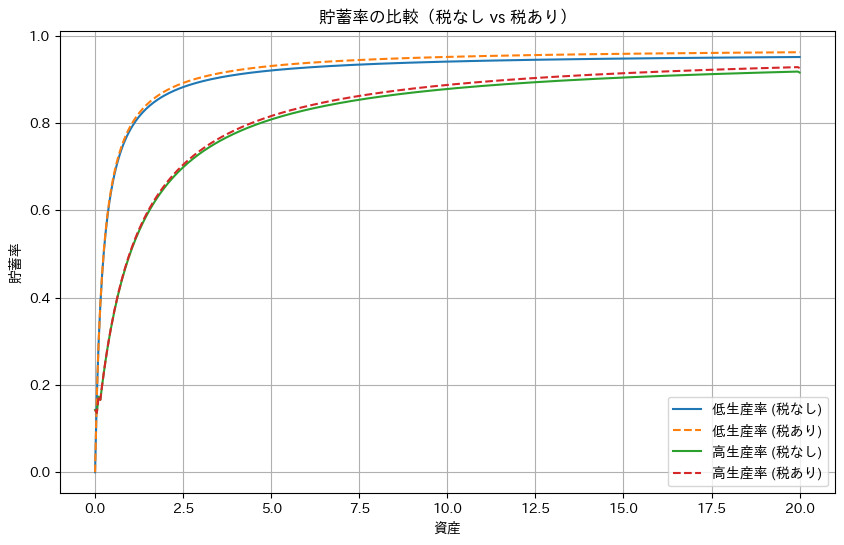

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen's method to discretize the AR(1) process
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

# パラメータを設定する関数
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH, 'a_l': a_l, 'a_u': a_u}
    return param

# 家計問題を解く関数
def solve_household(param, r, w, tau_k=0):
    NA, NH, h, a_l, a_u, sigma, beta, pi = param['NA'], param['NH'], param['h'], param['a_l'], param['a_u'], param['sigma'], param['beta'], param['pi']
    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)

    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + (1 - tau_k) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol, test = 1e-6, 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih] + beta * np.dot(v, pi[ih, :])
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus.astype(int)]
    c = w*h[:, np.newaxis] + (1.0 + (1 - tau_k) * r) * a[np.newaxis, :] - aplus.T
    return aplus, iaplus, c

# 貯蓄率をプロットする関数
def plot_savings_rate_comparison(param, r, w, tau_k, title):
    # 資本所得税なしの場合
    decisions_no_tax = solve_household(param, r, w)
    aplus_no_tax, c_no_tax = decisions_no_tax[0], decisions_no_tax[2]

    # 資本所得税ありの場合
    decisions_with_tax = solve_household(param, r, w, tau_k)
    aplus_with_tax, c_with_tax = decisions_with_tax[0], decisions_with_tax[2]

    a = np.linspace(param['a_l'], param['a_u'], param['NA'])

    plt.figure(figsize=(10, 6))

    # 低生産率の場合
    plt.plot(a, aplus_no_tax[:, 0]/(c_no_tax[0, :] + aplus_no_tax[:, 0]), label='低生産率 (税なし)', linestyle='-')
    plt.plot(a, aplus_with_tax[:, 0]/(c_with_tax[0, :] + aplus_with_tax[:, 0]), label='低生産率 (税あり)', linestyle='--')

    # 高生産率の場合
    plt.plot(a, aplus_no_tax[:, 1]/(c_no_tax[1, :] + aplus_no_tax[:, 1]), label='高生産率 (税なし)', linestyle='-')
    plt.plot(a, aplus_with_tax[:, 1]/(c_with_tax[1, :] + aplus_with_tax[:, 1]), label='高生産率 (税あり)', linestyle='--')

    plt.xlabel("資産")
    plt.ylabel("貯蓄率")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# パラメータを設定
param = setPar()
r, w = 0.04, 1
tau_k = 0.3  # 資本所得税率

# プロットを表示
plot_savings_rate_comparison(param, r, w, tau_k, "貯蓄率の比較（税なし vs 税あり）")


(3)

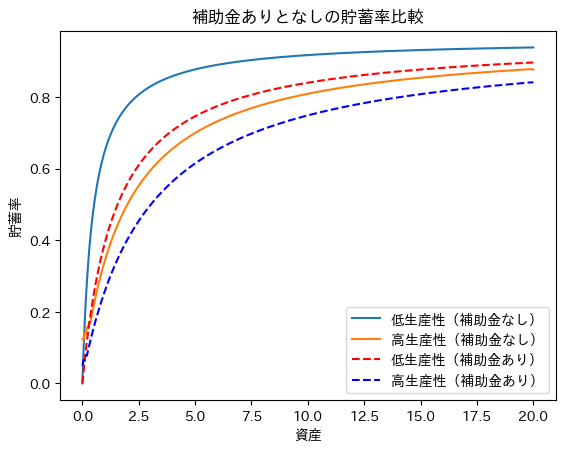

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 家計問題の解法（補助金を考慮）
def solve_household_with_subsidy(param, r, w, T):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] + T - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] + T - aplus[ia, ih]
    return aplus, iaplus, c

# 主要変数のプロット
def plot_combined_results(aplus_no_subsidy, c_no_subsidy, aplus_with_subsidy, c_with_subsidy, a):
    plt.plot(a, aplus_no_subsidy[:, 0] / (c_no_subsidy[:, 0] + aplus_no_subsidy[:, 0]), label='低生産性（補助金なし）')
    plt.plot(a, aplus_no_subsidy[:, 1] / (c_no_subsidy[:, 1] + aplus_no_subsidy[:, 1]), label='高生産性（補助金なし）')
    plt.plot(a, aplus_with_subsidy[:, 0] / (c_with_subsidy[:, 0] + aplus_with_subsidy[:, 0]), 'r--', label='低生産性（補助金あり）')
    plt.plot(a, aplus_with_subsidy[:, 1] / (c_with_subsidy[:, 1] + aplus_with_subsidy[:, 1]), 'b--', label='高生産性（補助金あり）')
    plt.xlabel("資産")
    plt.ylabel("貯蓄率")
    plt.title("補助金ありとなしの貯蓄率比較")
    plt.legend()
    plt.show()

# パラメータ設定
param = {
    'sigma': 1.5, 'beta': 0.98, 'pi': np.array([[0.9, 0.1], [0.1, 0.9]]),
    'h': np.exp(np.array([-0.7, 0.7])), 'NA': 401, 'NH': 2,
    'a_l': 0, 'a_u': 20, 'alpha': 0.25, 'delta': 0.03
}

# 金利と賃金の設定
r, w = 0.04, 1
T = 1  # 一括補助金

# 家計問題の解法（補助金なし）
aplus_no_subsidy, iaplus_no_subsidy, c_no_subsidy = solve_household_with_subsidy(param, r, w, 0.0)
# 家計問題の解法（補助金あり）
aplus_with_subsidy, iaplus_with_subsidy, c_with_subsidy = solve_household_with_subsidy(param, r, w, T)

# 結果のプロット
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plot_combined_results(aplus_no_subsidy, c_no_subsidy, aplus_with_subsidy, c_with_subsidy, a)


(4)

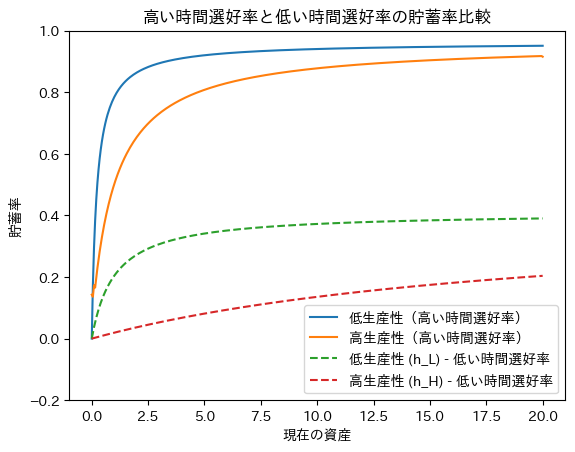

In [22]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import japanize_matplotlib

# タウチェン法によるマルコフ過程の離散化
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# パラメータ設定
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# 家計問題の解法
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# 貯蓄率の計算（低い時間選好率）
def calc_saving_rate_low_beta(a_t, h, beta_low, r, w):
    c_t = w * h + (1 + r) * a_t - a_t / (1 + beta_low)
    a_t_plus_1 = beta_low * (w * h + (1 + r) * a_t - c_t)
    saving_rate = a_t_plus_1 / (c_t + a_t_plus_1)
    return saving_rate

# 主要変数のプロット
def plot_results(aplus_high, c_high, saving_rate_L_low_beta, saving_rate_H_low_beta, a, a_t_grid):
    plt.plot(a, aplus_high[:, 0] / (c_high[:, 0] + aplus_high[:, 0]), label='低生産性（高い時間選好率）', linestyle='-')
    plt.plot(a, aplus_high[:, 1] / (c_high[:, 1] + aplus_high[:, 1]), label='高生産性（高い時間選好率）', linestyle='-')
    plt.plot(a_t_grid, saving_rate_L_low_beta, label='低生産性 (h_L) - 低い時間選好率', linestyle='--')
    plt.plot(a_t_grid, saving_rate_H_low_beta, label='高生産性 (h_H) - 低い時間選好率', linestyle='--')
    plt.xlabel('現在の資産')
    plt.ylabel('貯蓄率')
    plt.ylim(-0.2, 1.0)
    plt.legend()
    plt.title("高い時間選好率と低い時間選好率の貯蓄率比較")
    plt.show()

# パラメータ設定（高い時間選好率）
param_high = setPar(beta=0.98)
# パラメータ設定（低い時間選好率）
param_low = setPar(beta=0.1)

# 金利と賃金の設定
r, w = 0.04, 1

# 家計問題の解法（高い時間選好率）
aplus_high, iaplus_high, c_high = solve_household(param_high, r, w)

# 生産性の設定
h_L = np.exp(-param_high['sigma'])
h_H = np.exp(param_high['sigma'])

# 資産のグリッドを設定
a_t_grid = np.linspace(0, 20, 200)

# 貯蓄率の計算（低い時間選好率）
beta_low = 0.1
saving_rate_L_low_beta = [calc_saving_rate_low_beta(a, h_L, beta_low, r, w) for a in a_t_grid]
saving_rate_H_low_beta = [calc_saving_rate_low_beta(a, h_H, beta_low, r, w) for a in a_t_grid]

# 結果のプロット
a = np.linspace(param_high['a_l'], param_high['a_u'], param_high['NA'])
plot_results(aplus_high, c_high, saving_rate_L_low_beta, saving_rate_H_low_beta, a,a_t_grid)
